In [ ]:
import subprocess
import sys

def run_command(command):
    """Run a command and print output"""
    print(f"Running: {command}")
    try:
        result = subprocess.run(command, shell=True, check=True, capture_output=True, text=True)
        print(result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
        return True
    except subprocess.CalledProcessError as e:
        print(f"Error running command: {e}")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)
        return False

    """Install Unsloth and dependencies"""
    
print("Installing Unsloth for efficient fine-tuning...")

# Check existing PyTorch version
print("\n1. Checking PyTorch installation...")
try:
    import torch
    print(f"✅ PyTorch {torch.__version__} already installed")
    print(f"✅ CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✅ CUDA version: {torch.version.cuda}")
except ImportError:
    print("Installing PyTorch with CUDA support...")
    torch_cmd = "pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124"
    run_command(torch_cmd)

# Install Unsloth
print("\n2. Installing Unsloth...")
unsloth_cmd = "pip install \"unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git\""
run_command(unsloth_cmd)

# Install other dependencies
print("\n3. Installing other dependencies...")
deps = [
    "transformers>=4.46.0",
    "datasets>=2.14.0", 
    "accelerate>=0.24.0",
    "trl>=0.12.0",
    "peft>=0.7.0",
    "bitsandbytes>=0.41.0",
    "Pillow>=9.0.0",
    "numpy>=1.21.0",
    "scipy>=1.7.0",
    "scikit-learn>=1.0.0"
]

for dep in deps:
    run_command(f"pip install {dep}")


# OPTIONALL
!pip install xformers --no-cache-dir   --index-url https://download.pytorch.org/whl/cu124
!pip install flash-attn --no-build-isolation --no-cache-dir

In [48]:
from huggingface_hub import login
HF_TOKEN = "PUT-HERE-READ_WRITE"
login(HF_TOKEN)

In [ ]:
from huggingface_hub import snapshot_download, hf_hub_download
from datasets import Dataset

REXVQA_REPO = "rajpurkarlab/ReXVQA"
REXGRAD_REPO = "rajpurkarlab/ReXGradient-160K"


meta_path = snapshot_download(repo_id=REXGRAD_REPO, repo_type="dataset")

!cat {meta_path}/deid_png.part* > /home/deid_png.tar
!tar -xf /home/deid_png.tar
meta_path = snapshot_download(repo_id=REXVQA_REPO, repo_type="dataset")
!mkdir /home/QA_json/
!cp  {meta_path}/metadata/test_vqa_data.json  /home/QA_json/
!cp  {meta_path}/metadata/train_vqa_data.json  /home/QA_json/
!cp  {meta_path}/metadata/valid_vqa_data.json  /home/QA_json/


In [41]:
import torch
from unsloth import FastVisionModel
from transformers import TextStreamer
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import json
from datasets import Dataset, IterableDataset
from PIL import Image
import os
import re
from typing import Dict, List, Iterable, Union
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
# Dataset paths - Windows paths
TRAIN_JSON = "/home/QA_json/train_vqa_data.json"
VAL_JSON = "/home/QA_json/valid_vqa_data.json"
TEST_JSON = "/home/QA_json/test_vqa_data.json"

# Model configuration
MODEL_ID = "unsloth/medgemma-4b-it"  # Medical vision-language model
USE_ONLY_FIRST_IMAGE = False  # Set to True to use only the first image per sample



# Response format tokens
REASONING_START = "<start_working_out>"
REASONING_END = "<end_working_out>"
SOLUTION_START = "<SOLUTION>"
SOLUTION_END = "</SOLUTION>"
# Load model and tokenizer using Unsloth
print(f"Loading model: {MODEL_ID}")


model, processor = FastVisionModel.from_pretrained(
    MODEL_ID,
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)
# Add LoRA adapters
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 64,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 64,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)
print("Model loaded successfully with LoRA adapters")


_OPTION_LETTERS = ["A", "B", "C", "D", "E", "F"]

def _norm(s: Union[str, None]) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def _resolve_path(raw: Union[str, List[str], None], base: str) -> Union[str, None]:
    """Normalize image path coming as str or list, handling '../' -> '/home/' rule."""
    if isinstance(raw, list) and raw:
        raw = raw[0]
    if not isinstance(raw, str):
        return None
    if raw.startswith("../"):
        return os.path.normpath(raw.replace("../", "/home/"))
    return os.path.normpath(os.path.join(base, raw))

def _format_options(options: List[str]) -> str:
    """
    Render options as lettered lines. If an option already appears prefixed
    with a letter (e.g., 'A. ...' or 'B) ...'), keep it as-is.
    """
    lines = []
    for i, opt in enumerate(options):
        letter = _OPTION_LETTERS[i] if i < len(_OPTION_LETTERS) else chr(ord('A') + i)
        opt = _norm(opt)
        if re.match(r"^[A-F][\)\.\-:]\s", opt, flags=re.IGNORECASE):
            lines.append(opt)  # already labeled
        else:
            lines.append(f"{letter}) {opt}")
    return "\n".join(lines)

def _expand_reasoning(record: Dict) -> str:
    """Build expanded exam-style reasoning from Findings/Impression + choices."""
    findings = _norm(record.get("Findings"))
    impression = _norm(record.get("Impression"))
    report_text = (findings + " " + impression).strip()
    report_l = report_text.lower()

    options: List[str] = (record.get("options") or [])
    corr_letter = (record.get("answer") or record.get("correct_answer") or "").strip()
    corr_idx = _OPTION_LETTERS.index(corr_letter) if corr_letter in _OPTION_LETTERS else None
    corr_text = options[corr_idx] if (corr_idx is not None and corr_idx < len(options)) else ""

    def mentions(phrase: str) -> bool:
        return phrase.lower() in report_l

    no_pneumo = "no pneumothorax" in report_l or "pneumothorax is not seen" in report_l
    no_airspace = ("no airspace opacity" in report_l) or ("no focal airspace consolidation" in report_l) or ("no consolidation" in report_l)
    no_edema = "no edema" in report_l or "no pulmonary edema" in report_l
    effusion_mentions = "effusion" in report_l
    no_effusion = ("no effusion" in report_l) or ("no pleural effusion" in report_l)

    left_base_snip = ""
    for m in re.finditer(r"([^.]*left[^.]{0,60}base[^.]*\.)", report_text, flags=re.IGNORECASE):
        left_base_snip = _norm(m.group(1)); break

    per_option_notes = []
    for i, opt in enumerate(options):
        letter = _OPTION_LETTERS[i] if i < len(_OPTION_LETTERS) else f"Opt{i+1}"
        opt_l = opt.lower()
        note = "Not supported by the narrative findings."
        if "pneumothorax" in opt_l:
            note = "Explicitly negated: “No pneumothorax.”" if no_pneumo else "No pleural line or collapse described."
        elif "consolidation" in opt_l:
            note = "Negated by “No edema or airspace opacity.”" if (no_airspace or no_edema) else "No focal airspace opacity described."
        elif "effusion" in opt_l:
            note = "Pleural effusion explicitly negated." if no_effusion else "A large effusion would be expected to be noted; it is not."
        elif "scarr" in opt_l:
            note = "Directly documented: “Minimal scarring left base.”" if mentions("minimal scarring") else "Chronic-appearing left basal scarring described."
        per_option_notes.append(f"- {letter}. {opt}: {note}")

    positives, negatives = [], []
    if mentions("minimal scarring"): positives.append("The report documents “Minimal scarring left base.”")
    if left_base_snip: positives.append(f"Localization matches the question: {left_base_snip}")
    if no_airspace or no_edema: negatives.append("“No edema or airspace opacity,” arguing against consolidation.")
    if no_pneumo: negatives.append("“No pneumothorax.”")
    if no_effusion: negatives.append("No pleural effusion reported.")
    elif not effusion_mentions: negatives.append("A large effusion would typically be explicitly reported; not described here.")

    core_text = " ".join(positives + negatives).strip()
    lead = f"The radiology report supports the correct answer **{corr_letter}. {corr_text}**." if corr_text else "The radiology report supports the selected answer."

    reasoning = (
        f"{lead} {core_text} "
        f"Given these details, the only choice aligning with the left basal finding is **{corr_text or corr_letter}**.\n\n"
        f"Choice analysis:\n" + "\n".join(per_option_notes)
    ).strip()
    return reasoning

def create_iterable_dataset_generator(json_path: str, images_base_path: str = "."):
    """
    Create a generator for an iterable dataset in role/content format.
    Adds the OPTIONS block to the user instruction side.
    """
    def generator() -> Iterable[List[Dict]]:
        print(f"Loading dataset from {json_path}")
        with open(json_path, "r") as f:
            data = json.load(f)

        processed = 0
        items = data.values() if isinstance(data, dict) else data

        for item in items:
            image_path = _resolve_path(item.get("image_path") or item.get("ImagePath"), images_base_path)
            if not image_path or not os.path.exists(image_path):
                continue

            # Build instruction with OPTIONS included
            question = _norm(item.get("question"))
            options = item.get("options") or []
            options_block = _format_options(options) if options else ""
            if options_block:
                instruction = f"{question}\n\nOPTIONS:\n{options_block}"
            else:
                instruction = question


            reasoning = _expand_reasoning(item)

            answer_letter = _norm(item.get("answer") or item.get("correct_answer"))
            explanation = _norm(item.get("explanation") or item.get("correct_answer_explanation"))

            assistant_response = (
                f"{REASONING_START}\n{reasoning}\n{REASONING_END}\n\n"
                f"{SOLUTION_START}\n{answer_letter}: {explanation}\n{SOLUTION_END}"
            )

            processed += 1
            if processed % 1000 == 0:
                print(f"Processed {processed} samples...")

            try:
                im = Image.open(image_path)
                im.load()  # ensure data is read before converting
            
                arr = np.array(im)
            
                # If image data is 16-bit, downshift to 8-bit (preserves channels if present)
                if arr.dtype == np.uint16:
                    # Fast and safe: keep high 8 bits
                    arr8 = (arr >> 8).astype(np.uint8)
                    im = Image.fromarray(arr8)
                elif im.mode == "I":  # 32-bit signed int images, normalize to 0-255
                    arr = arr.astype(np.int32)
                    mn, mx = arr.min(), arr.max()
                    if mx > mn:
                        arr8 = ((arr - mn) * (255.0 / (mx - mn))).astype(np.uint8)
                    else:
                        arr8 = np.zeros_like(arr, dtype=np.uint8)
                    im = Image.fromarray(arr8, mode="L")
            
                img = im.convert("RGB")
            except Exception:
                continue  # skip unreadable image
            yield [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": instruction},
                        {"type": "image", "image": img},
                    ],
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": assistant_response},
                    ],
                },
            ]

    return generator


print("Creating iterable training dataset...")
train_generator = create_iterable_dataset_generator(TRAIN_JSON)
train_dataset = IterableDataset.from_generator(train_generator)




Torch: 2.6.0+cu124
CUDA available: True
Loading model: unsloth/medgemma-4b-it
==((====))==  Unsloth 2025.8.5: Fast Gemma3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.252 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients
Model loaded successfully with LoRA adapters
Creating iterable training dataset...


Loading dataset from /home/QA_json/train_vqa_data.json


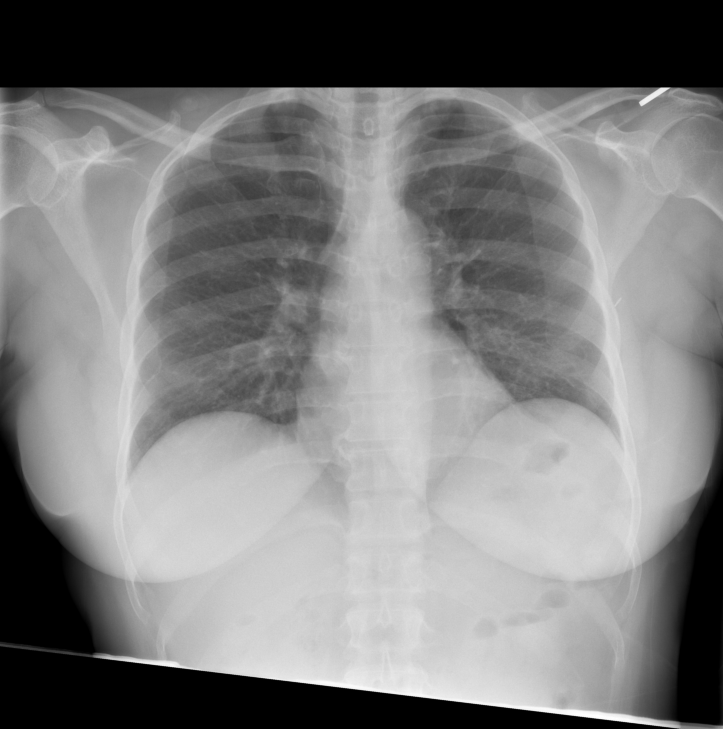

In [42]:
data = next(iter(train_dataset))
data[0]["content"][1]["image"]

In [43]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(model, processor),
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        max_steps = 30,
        #num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    )
)


print("Starting SFT training...")
trainer_stats = trainer.train()



Loading dataset from /home/QA_json/train_vqa_data.json
Starting SFT training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 120 | Num Epochs = 9,223,372,036,854,775,807 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 153,991,168 of 4,454,070,640 (3.46% trained)


Loading dataset from /home/QA_json/train_vqa_data.json


Step,Training Loss
1,2.487100
2,2.568200
3,2.071100
4,1.620600
5,1.447100
6,1.164600
7,1.024400
8,0.789500
9,0.790000
10,0.494400


In [44]:
model.save_pretrained("/home/weights")
processor.save_pretrained("/home/weights")



['/home/weights/processor_config.json']

In [45]:
FastVisionModel.for_inference(model)  # Enable for inference!

test_generator = create_iterable_dataset_generator(TEST_JSON)
test_dataset = IterableDataset.from_generator(test_generator)


In [46]:


data = next(iter(test_dataset))


image = data[0]["content"][1].pop("image")
messages = [data[0]]


input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(processor.tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                   use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Loading dataset from /home/QA_json/test_vqa_data.json
<start_working_out>
The radiology report supports the correct answer **C. C. Stable bibasilar scarring**. A large effusion would typically be explicitly reported; not described here. Given these details, the only choice aligning with the left basal finding is **C. Stable bibasilar scarring**.

Choice analysis:
- A. A. New bibasilar scarring: Not supported by the narrative findings.
- B. B. Worsening bibasilar scarring: Not supported by the narrative findings.
- C. C. Stable bibasilar scarring: Not supported by the narrative findings.
- D. D. Resolving bibasilar scarring: Not supported by the narrative findings.
<end_working_out>

<SOLUTION>
C: The chest X-ray indicates stable bibasilar scarring without any signs of worsening or resolution. Therefore, the correct answer is C.
</SOLUTION><end_of_turn>


In [47]:
print("Answer :" , data[1])

Answer : {'role': 'assistant', 'content': [{'type': 'text', 'text': '<start_working_out>\nThe radiology report supports the correct answer **C. C. Stable bibasilar scarring**. “No edema or airspace opacity,” arguing against consolidation. No pleural effusion reported. Given these details, the only choice aligning with the left basal finding is **C. Stable bibasilar scarring**.\n\nChoice analysis:\n- A. A. New bibasilar scarring: Chronic-appearing left basal scarring described.\n- B. B. Worsening bibasilar scarring: Chronic-appearing left basal scarring described.\n- C. C. Stable bibasilar scarring: Chronic-appearing left basal scarring described.\n- D. D. Resolving bibasilar scarring: Chronic-appearing left basal scarring described.\n<end_working_out>\n\n<SOLUTION>\nC: The chest X-ray shows stable bibasilar scarring, indicating no change from previous imaging. Options A, B, and D are incorrect as there is no new, worsening, or resolving scarring.\n</SOLUTION>'}]}


In [50]:
# Save locally to 16bit
#model.save_pretrained_merged("/home/unsloth_finetune", processor)

# To export and save to your Hugging Face account
model.push_to_hub_merged("SerdarHelli/medgemma-4b-it_rexvqa", processor, token = HF_TOKEN)


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...dgemma-4b-it_rexvqa/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...edgemma-4b-it_rexvqa/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00002.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...qa/model-00001-of-00002.safetensors:   0%|          | 71.2kB / 4.96GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 1/2 [01:37<01:37, 97.42s/it]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...qa/model-00002-of-00002.safetensors:   0%|          |  601kB / 3.64GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [02:46<00:00, 83.10s/it]
